In [1]:
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def preprocess_data(X, Y):
    """
    function that pre-processes the CIFAR10 dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = K.applications.densenet.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

In [3]:
# load the Cifar10 dataset, 50,000 training images and 10,000 test images (here used as validation data)
(x_train, y_train), (x_test, y_test) = K.datasets.cifar10.load_data()
# preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

170500096/170498071 [==============================] - 2s 0us/step


In [4]:
input_tensor = K.Input(shape=(32, 32, 3))
# resize images to the image size upon which the network was pre-trained
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)

In [5]:
# reduce learning rate when val_accuracy has stopped improving
lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
# callback to save the Keras model and (best) weights obtained on an epoch basis. here, the trained (compiled) model is saved in the current working directory as 'cifar10.h5'
checkpoint = K.callbacks.ModelCheckpoint('cifar10.h5',
                                         monitor='val_accuracy',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')

In [6]:
train_datagen = K.preprocessing.image.ImageDataGenerator(
                                          # rotation_range=40,
                                          # width_shift_range=0.2,
                                          # height_shift_range=0.2,
                                          # shear_range=0.2,
                                          # zoom_range=0.2,
                                          horizontal_flip=True,
                                          # fill_mode='nearest'
                                          )
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=512)
val_datagen = K.preprocessing.image.ImageDataGenerator(
                                        # rotation_range=40,
                                        # width_shift_range=0.2,
                                        # height_shift_range=0.2,
                                        # shear_range=0.2,
                                        # zoom_range=0.2,
                                        horizontal_flip=True,
                                        # fill_mode='nearest'
                                        )
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=512)
train_steps_per_epoch = x_train.shape[0] // 512
val_steps_per_epoch = x_test.shape[0] // 512

In [7]:
# weights are initialized as per the he et al. method
initializer = K.initializers.he_normal()

model = K.applications.DenseNet201(include_top=False,
                                   weights='imagenet',
                                   input_tensor=resized_images,
                                   input_shape=(224, 224, 3),
                                   pooling='max',
                                   classes=1000)
# make the weights and biases of the base model non-trainable by "freezing" each layer of the DenseNet201 network
for layer in model.layers:
  if layer.name == 'conv5_block1_0_bn':
    break
  layer.trainable = False

model.summary()    

74842112/74836368 [==============================] - 1s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           lambda[0][0]                     
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
_______________________

In [8]:
output = model.layers[-1].output
# reshape the output feature map of the base model before passing the data on to the Dense layers of the classifier head
flatten = K.layers.Flatten()
output = flatten(output)
layer_256 = K.layers.Dense(units=256,
                           activation='elu',
                           kernel_initializer=initializer,
                           kernel_regularizer=K.regularizers.l2())
output = layer_256(output)
dropout = K.layers.Dropout(0.5)
output = dropout(output)
softmax = K.layers.Dense(units=10,
                         activation='softmax',
                         kernel_initializer=initializer,
                         kernel_regularizer=K.regularizers.l2())
output = softmax(output)
model = K.models.Model(inputs=input_tensor, outputs=output)

model.summary()

model.compile(
         optimizer=K.optimizers.Adam(learning_rate=1e-4),
         loss='categorical_crossentropy',
         metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           lambda[0][0]                     
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
______________________________________________________________________________________________

In [9]:
%%time
history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=val_generator,
                    validation_steps=val_steps_per_epoch,
                    epochs=20,
                    shuffle=True,
                    callbacks=[lr_reduce, checkpoint],
                    verbose=1)

Epoch 1/20
97/97 [==============================] - 186s 2s/step - loss: 7.3945 - accuracy: 0.5826 - val_loss: 4.4489 - val_accuracy: 0.8965

Epoch 00001: val_accuracy improved from -inf to 0.89648, saving model to cifar10.h5
Epoch 2/20
97/97 [==============================] - 149s 2s/step - loss: 4.2445 - accuracy: 0.8899 - val_loss: 3.5601 - val_accuracy: 0.9188

Epoch 00002: val_accuracy improved from 0.89648 to 0.91879, saving model to cifar10.h5
Epoch 3/20
97/97 [==============================] - 149s 2s/step - loss: 3.3667 - accuracy: 0.9264 - val_loss: 2.9639 - val_accuracy: 0.9277

Epoch 00003: val_accuracy improved from 0.91879 to 0.92773, saving model to cifar10.h5
Epoch 4/20
97/97 [==============================] - 149s 2s/step - loss: 2.7863 - accuracy: 0.9453 - val_loss: 2.5475 - val_accuracy: 0.9331

Epoch 00004: val_accuracy improved from 0.92773 to 0.93308, saving model to cifar10.h5
Epoch 5/20
97/97 [==============================] - 149s 2s/step - loss: 2.3609 - accur

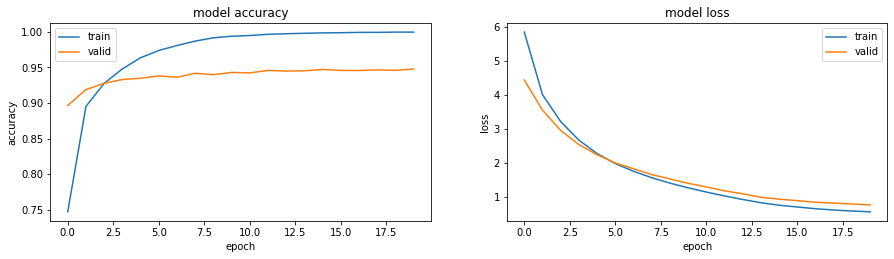

In [10]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [11]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 31s 85ms/step - loss: 0.7808 - accuracy: 0.9450


[0.7808093428611755, 0.9449999928474426]